In [3]:
%%capture --no-stderr

!pip install -qU langgraph langchain-groq

In [8]:
import getpass
import os

def _set_env(var  :str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}:")
        
_set_env("GROQ_API_KEY")
    

In [11]:
os.environ["GROQ_API_KEY"] = getpass.getpass("enter the api")


enter the api ········


In [60]:
os.environ["LANGSMIT_API_KEY"] = getpass.getpass("enter the api")


enter the api ········


In [31]:
from langchain_core.tools import tool


@tool
def get_weather(location: str):
    """Call to get the current weather."""
    if location == "san francisco":
        raise ValueError("Input queries must be proper nouns")
    elif location == "San Francisco":
        return "It's 60 degrees and foggy."
    else:
        raise ValueError("Invalid input.")

In [26]:
from typing import Literal # it is going to store the base data for the software development

from langchain_groq import ChatGroq
from langgraph.graph import StateGraph, MessagesState
from langgraph.prebuilt import ToolNode

tool_node = ToolNode([get_weather])

model_with_tools = ChatGroq(
    model="mixtral-8x7b-32768", temperature=0
).bind_tools([get_weather])

#tool_call -> responding to the prompt of generating output that matches a user-defined schema.


def should_continue(state: MessagesState) -> Literal["tools", "__end__"]:
    messages = state["messages"]
    last_message = messages[-1]
    if last_message.tool_calls:
        return "tools"
    return "__end__"

def call_model(state: MessagesState):
    messages = state["messages"]
    response = model_with_tools.invoke(messages)
    return {"messages": [response]}


workflow = StateGraph(MessagesState)

workflow.add_node("agent", call_model)
workflow.add_node("tools", tool_node)


workflow.add_edge("__start__", "agent")
workflow.add_conditional_edges(
    "agent",
    should_continue
)

workflow.add_edge("tools", "agent")
app = workflow.compile()

# tool is the get_weather

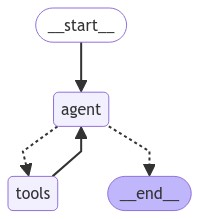

In [29]:
from IPython.display import Image, display

try: 
    display(Image(app.get_graph().draw_mermaid_png()))
    
except Exception:
    pass

In [32]:
response = app.invoke(
    {"messages": [("human", "what is the weather in san francisco?")]},
)

for message in response["messages"]:
    string_representation = f"{message.type.upper()}: {message.content}\n"
    print(string_representation)

HUMAN: what is the weather in san francisco?

AI: 

TOOL: It's 60 degree and foggy

AI: It's 60 degrees and foggy in San Francisco.



In [61]:
from langchain_core.output_parsers import StrOutputParser
from langchain.pydantic_v1 import BaseModel, conlist


class HaikuRequest(BaseModel):
    topic: conlist(str, min_items=3, max_items=3)


@tool
def master_haiku_generator(request: HaikuRequest):
    """Generates a haiku based on the provided topics."""
    model = ChatGroq(model ="mixtral-8x7b-32768", temperature=0)
    chain = model | StrOutputParser()
    topics = ", ".join(request.topic)
    haiku = chain.invoke(f"Write a haiku about {topics}")
    return haiku


tool_node = ToolNode([master_haiku_generator])

model = ChatGroq(model ="mixtral-8x7b-32768", temperature=0)
model_with_tools = model.bind_tools([master_haiku_generator])


def should_continue(state: MessagesState) -> Literal["tools", "__end__"]:
    messages = state["messages"]
    last_message = messages[-1]
    if last_message.tool_calls:
        return "tools"
    return "__end__"


def call_model(state: MessagesState):
    messages = state["messages"]
    response = model_with_tools.invoke(messages)
    return {"messages": [response]}


workflow = StateGraph(MessagesState)

# Define the two nodes we will cycle between
workflow.add_node("agent", call_model)
workflow.add_node("tools", tool_node)

workflow.add_edge("__start__", "agent")
workflow.add_conditional_edges(
    "agent",
    should_continue,
)
workflow.add_edge("tools", "agent")

app = workflow.compile()

response = app.invoke(
    {"messages": [("human", "Write me an incredible haiku about water.")]},
    {"recursion_limit": 10},
)

for message in response["messages"]:
    string_representation = f"{message.type.upper()}: {message.content}\n"
    print(string_representation)

HUMAN: Write me an incredible haiku about water.

AI: 

TOOL: Water's mirror, life
Reflections dance and change
Nature's fleeting art

AI: Water's mirror, life
Reflections dance and change
Nature's fleeting art



In [62]:
import json

from langchain_core.messages import AIMessage
from langchain_core.messages.modifier import RemoveMessage

class HaikuRequest(BaseModel):
    topic: conlist(str, min_items = 3, max_items = 3)
    
@tool

def call_tool(request: HaikuRequest):
    """Generate a Haiku on the based of the provided topics """
    model = ChatGroq(model ="mixtral-8x7b-32768", temprature = 0)
    
    chain = model|StrOutputParser()
    topics = ", ".join(request.topic)
    haiku = chain.invoke(f"Write a haiku about {topics}")
    return haiku

tool_node = ToolNode([master_haiku_generator])

model = ChatGroq(model ="mixtral-8x7b-32768", temperature = 0)
model_with_tools = model.bind_tools([master_haiku_generator])

better_model = ChatGroq(model="llama2-70b-4096", temperature=0)
better_model_with_tools = better_model.bind_tools([master_haiku_generator])


def should_fallback(
    state: MessagesState,
) -> Literal["agent", "remove_failed_tool_call_attempt"]:
    messages = state["messages"]
    failed_tool_messages = [
        msg
        for msg in messages
        if isinstance(msg, ToolMessage)
        and msg.additional_kwargs.get("error") is not None
    ]
    if failed_tool_messages:
        return "remove_failed_tool_call_attempt"
    return "agent"


def call_model(state: MessagesState):
    messages = state["messages"]
    response = model_with_tools.invoke(messages)
    return {"messages": [response]}


def remove_failed_tool_call_attempt(state: MessagesState):
    messages = state["messages"]
    # Remove all messages from the most recent
    # instance of AIMessage onwards.
    last_ai_message_index = next(
        i
        for i, msg in reversed(list(enumerate(messages)))
        if isinstance(msg, AIMessage)
    )
    messages_to_remove = messages[last_ai_message_index:]
    return {"messages": [RemoveMessage(id=m.id) for m in messages_to_remove]}


# Fallback to a better model if a tool call fails
def call_fallback_model(state: MessagesState):
    messages = state["messages"]
    response = better_model_with_tools.invoke(messages)
    return {"messages": [response]}


workflow = StateGraph(MessagesState)

workflow.add_node("agent", call_model)
workflow.add_node("tools", call_tool)
workflow.add_node("remove_failed_tool_call_attempt", remove_failed_tool_call_attempt)
workflow.add_node("fallback_agent", call_fallback_model)

workflow.add_edge("__start__", "agent")
workflow.add_conditional_edges(
    "agent",
    should_continue,
)
workflow.add_conditional_edges("tools", should_fallback)
workflow.add_edge("remove_failed_tool_call_attempt", "fallback_agent")
workflow.add_edge("fallback_agent", "tools")

app = workflow.compile()
    
    

    

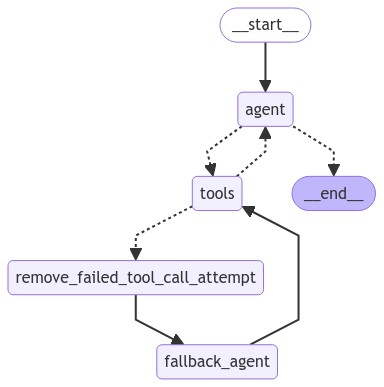

In [63]:
try:
    display(Image(app.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [64]:
stream = app.stream(
    {"messages": [("human", "Write me an incredible haiku about water.")]},
    {"recursion_limit": 10},
)

for chunk in stream:
    print(chunk)

{'agent': {'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_bw2q', 'function': {'arguments': '{"request":{"topic":["water","reflection","life"]}}', 'name': 'master_haiku_generator'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 113, 'prompt_tokens': 1329, 'total_tokens': 1442, 'completion_time': 0.182199932, 'prompt_time': 0.084173321, 'queue_time': None, 'total_time': 0.26637325300000003}, 'model_name': 'mixtral-8x7b-32768', 'system_fingerprint': 'fp_c5f20b5bb1', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-b409a7e1-cb9d-4322-96bd-260b81894e62-0', tool_calls=[{'name': 'master_haiku_generator', 'args': {'request': {'topic': ['water', 'reflection', 'life']}}, 'id': 'call_bw2q', 'type': 'tool_call'}], usage_metadata={'input_tokens': 1329, 'output_tokens': 113, 'total_tokens': 1442})]}}


ValidationError: 1 validation error for call_toolSchema
request
  field required (type=value_error.missing)